In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import configparser
from sqlalchemy import create_engine  
import statsmodels.api as sm
import squarify
import plotly.express as px

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso,Ridge
from sklearn.feature_selection import mutual_info_classif
#Модели регрессии

#Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor
#Elastic Net Regression
from sklearn.linear_model import ElasticNet
#Stochastic Gradient Descent Regression
from sklearn.linear_model import SGDRegressor
#Support Vector Machine
from sklearn.svm import SVR
#Bayesian Ridge Regression
from sklearn.linear_model import BayesianRidge
#CatBoost Regressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
#Linear Regression
from sklearn.linear_model import LinearRegression
#Ridge and Lasso regression
#XGBoost Regressor
from xgboost import XGBRegressor
#LGBM Regressor
#from lightgbm import LGBMRegressor

# Подбор гиперпараметров
import datetime
from sklearn.metrics import accuracy_score

import pickle
%matplotlib inline

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [76]:
#Ставим кол-во выводимых строк и столбцов 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#Отключаем предупреждения

warnings.filterwarnings('ignore')

In [77]:
data_path = '/home/aleksey/Classical_ML/Exploring_Mental_Health_Data/train.csv'

In [78]:
with open(data_path) as f:
    df_train = pd.read_csv(f)

In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [80]:
df_train.describe().T.style.background_gradient(subset=['std'], cmap='Greens').background_gradient(subset=['mean'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
id,140700.000000,70349.500000,40616.735775,0.000000,35174.750000,70349.500000,105524.250000,140699.000000
Age,140700.000000,40.388621,12.384099,18.000000,29.000000,42.000000,51.000000,60.000000
Academic Pressure,27897.000000,3.142273,1.380457,1.000000,2.000000,3.000000,4.000000,5.000000
Work Pressure,112782.000000,2.998998,1.405771,1.000000,2.000000,3.000000,4.000000,5.000000
CGPA,27898.000000,7.658636,1.464466,5.030000,6.290000,7.770000,8.920000,10.000000
Study Satisfaction,27897.000000,2.944940,1.360197,1.000000,2.000000,3.000000,4.000000,5.000000
Job Satisfaction,112790.000000,2.974404,1.416078,1.000000,2.000000,3.000000,4.000000,5.000000
Work/Study Hours,140700.000000,6.252679,3.853615,0.000000,3.000000,6.000000,10.000000,12.000000
Financial Stress,140696.000000,2.988983,1.413633,1.000000,2.000000,3.000000,4.000000,5.000000
Depression,140700.000000,0.181713,0.385609,0.000000,0.000000,0.000000,0.000000,1.000000


In [81]:
#Проверка на дубли

df_train[df_train.duplicated()]

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


In [82]:
#Функции для создания таблицы по пропускам и визуализации фичей с пропусками

'''
data_frame - Датафрейм который передаем в функцию на проверку
missings_percent - % пустых значений который хотим проверить например missings_percent>0 покажет все колонки где есть пропуски

'''
def missings(data_frame,missings_percent):

    total = data_frame.isnull().sum().sort_values(ascending=False)
    percent = (data_frame.isnull().sum()/data_frame.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[(missing_data['Percent']>missings_percent)]
    
    return missing_data.style.background_gradient(subset=['Percent'], cmap='Reds')
    
def missings_bar_vizualisation(data_frame,missings_percent):
    
    try:

        total = data_frame.isnull().sum().sort_values(ascending=False)
        percent = (data_frame.isnull().sum()/data_frame.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data[(missing_data['Percent']>missings_percent)]
    
        #plt.rcParams["figure.figsize"] = (10,5)
        sns.barplot(x=missing_data.index,y=missing_data['Percent'],data = missing_data)
        plt.xticks(rotation=70)
        plt.show()
    
    except ValueError:
        
        print('No missings')

In [83]:
missings(df_train,0)

,Total,Percent
Study Satisfaction,112803,80.172708
Academic Pressure,112803,80.172708
CGPA,112802,80.171997
Profession,36630,26.034115
Work Pressure,27918,19.842217
Job Satisfaction,27910,19.836532
Dietary Habits,4,0.002843
Financial Stress,4,0.002843
Degree,2,0.001421


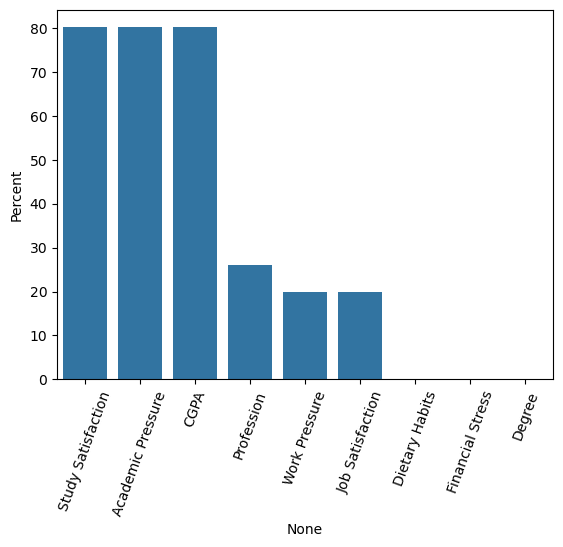

In [84]:
missings_bar_vizualisation(df_train,0)

In [85]:
features = df_train.columns.to_list()
uniques = []
for f in features:
    item = {'feature':f}
    count = len(df_train[f].unique())
    item['count'] = count
    if count < 10:
        item['values'] = df_train[f].unique().tolist()
    elif count < df_train.shape[0]:
        item['values'] = df_train[f].unique().tolist()[:10] + ['...']
    else:
        item['values'] = ['All values are unique']
    uniques.append(item)
df_uniques = pd.DataFrame(uniques)
df_uniques = df_uniques.set_index('feature')

df_uniques.style.background_gradient(subset=['count'], cmap='Reds')

,count,values
feature,,
id,140700,['All values are unique']
Name,422,"['Aaradhya', 'Vivan', 'Yuvraj', 'Rhea', 'Vani', 'Ritvik', 'Rajveer', 'Aishwarya', 'Simran', 'Utkarsh', '...']"
Gender,2,"['Female', 'Male']"
Age,43,"[49.0, 26.0, 33.0, 22.0, 30.0, 59.0, 47.0, 38.0, 24.0, 42.0, '...']"
City,98,"['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur', 'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', '...']"
Working Professional or Student,2,"['Working Professional', 'Student']"
Profession,65,"['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst', 'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist', 'Plumber', '...']"
Academic Pressure,6,"[nan, 5.0, 2.0, 3.0, 4.0, 1.0]"
Work Pressure,6,"[5.0, 4.0, nan, 1.0, 2.0, 3.0]"


### EDA

In [86]:
#Numeric EDA func

def Numeric_viz(data_frame,cols,cell):

    heart_CAT = data_frame.columns.to_list()

#  Categorical Data

    b = cols  # number of columns
    a = math.ceil(len(heart_CAT)/b)*3  # number of rows
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (20,50))

    for i in heart_CAT:
        
        if data_frame[i].dtype not in ['object']:
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.boxplot(data = data_frame, x = i)
            c = c + 1
    
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data=data_frame, x=i,hue=cell)
            c = c + 1
    fig.tight_layout(h_pad=2,w_pad=2)
    
    plt.show()

In [87]:
def cat_viz(data_frame,cols,cell):

    heart_CAT = data_frame.columns.to_list()

#  Categorical Data

    b = cols  # number of columns
    a = math.ceil(len(heart_CAT)/b)*3  # number of rows
    c = 1  # initialize plot counter

    fig = plt.figure(figsize = (20,50))

    for i in heart_CAT:
        
        if data_frame[i].dtype in ['object']:
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.countplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.histplot(data = data_frame, x = i)
            c = c + 1
            
            plt.subplot(a, b, c)
            plt.xlabel(i)
            sns.countplot(data=data_frame, x=i,hue=cell)
            c = c + 1
        
    fig.tight_layout(h_pad=2,w_pad=2)
    
    plt.show()

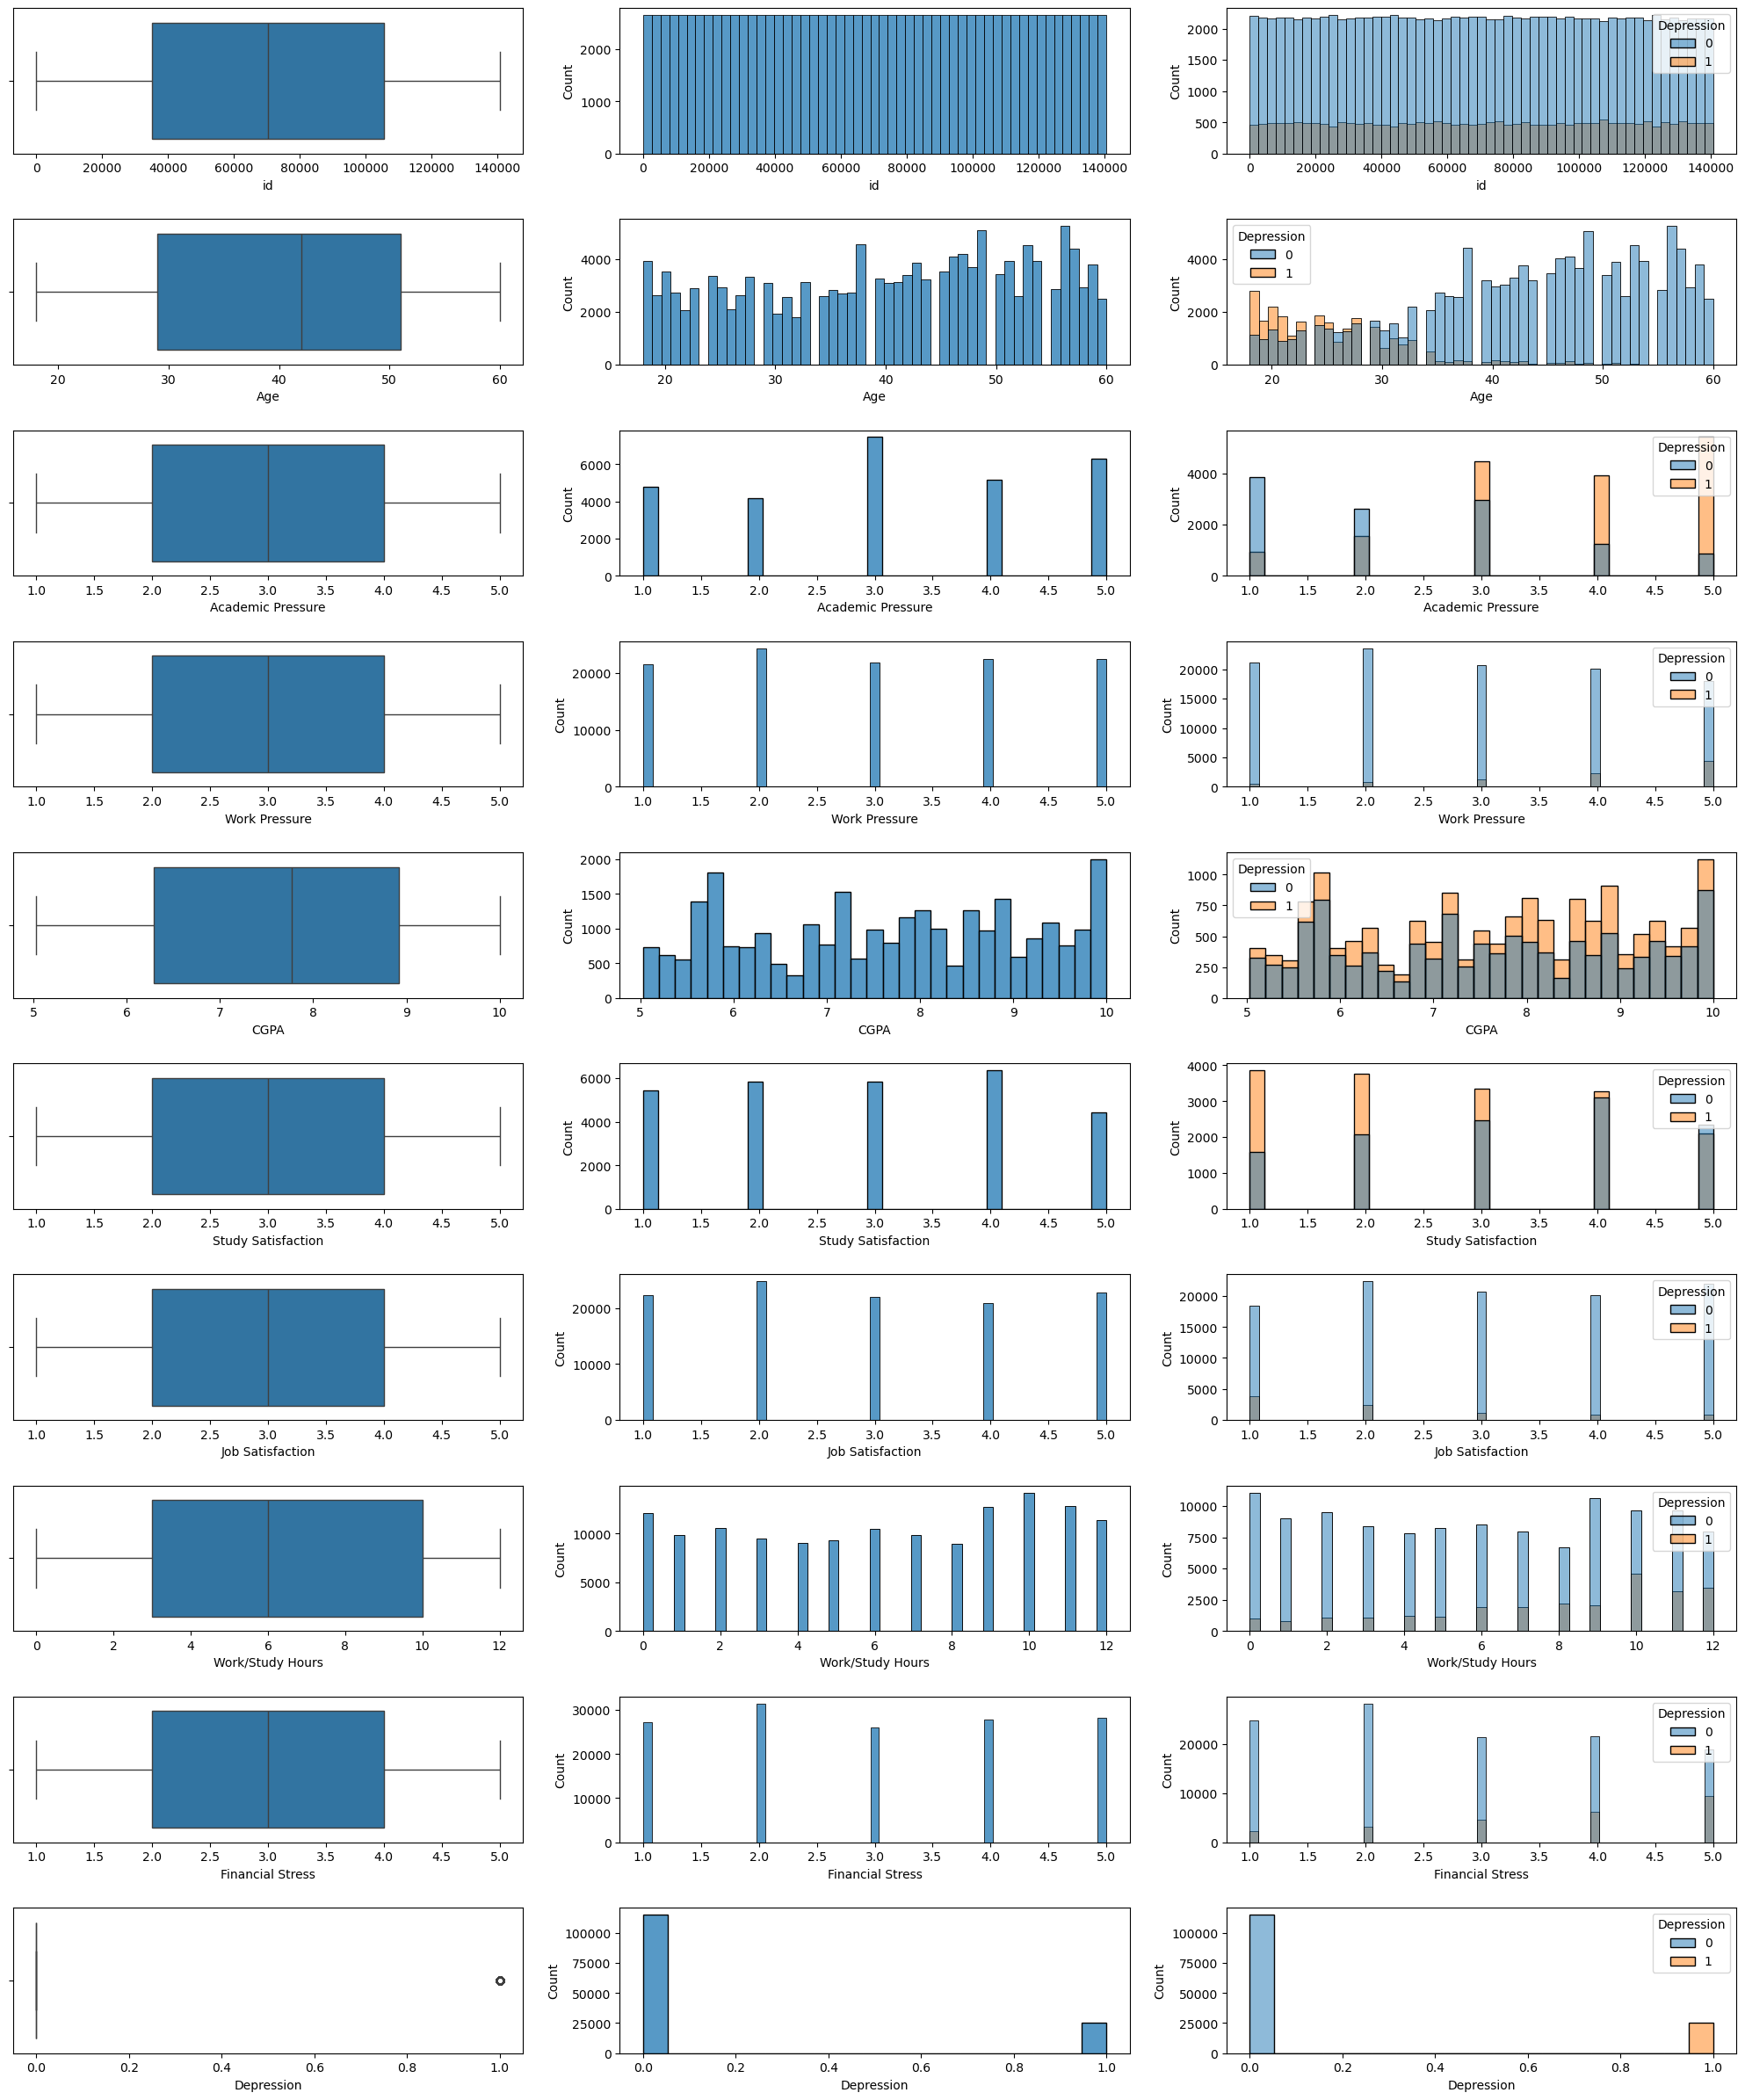

In [88]:
Numeric_viz(df_train,3,'Depression')

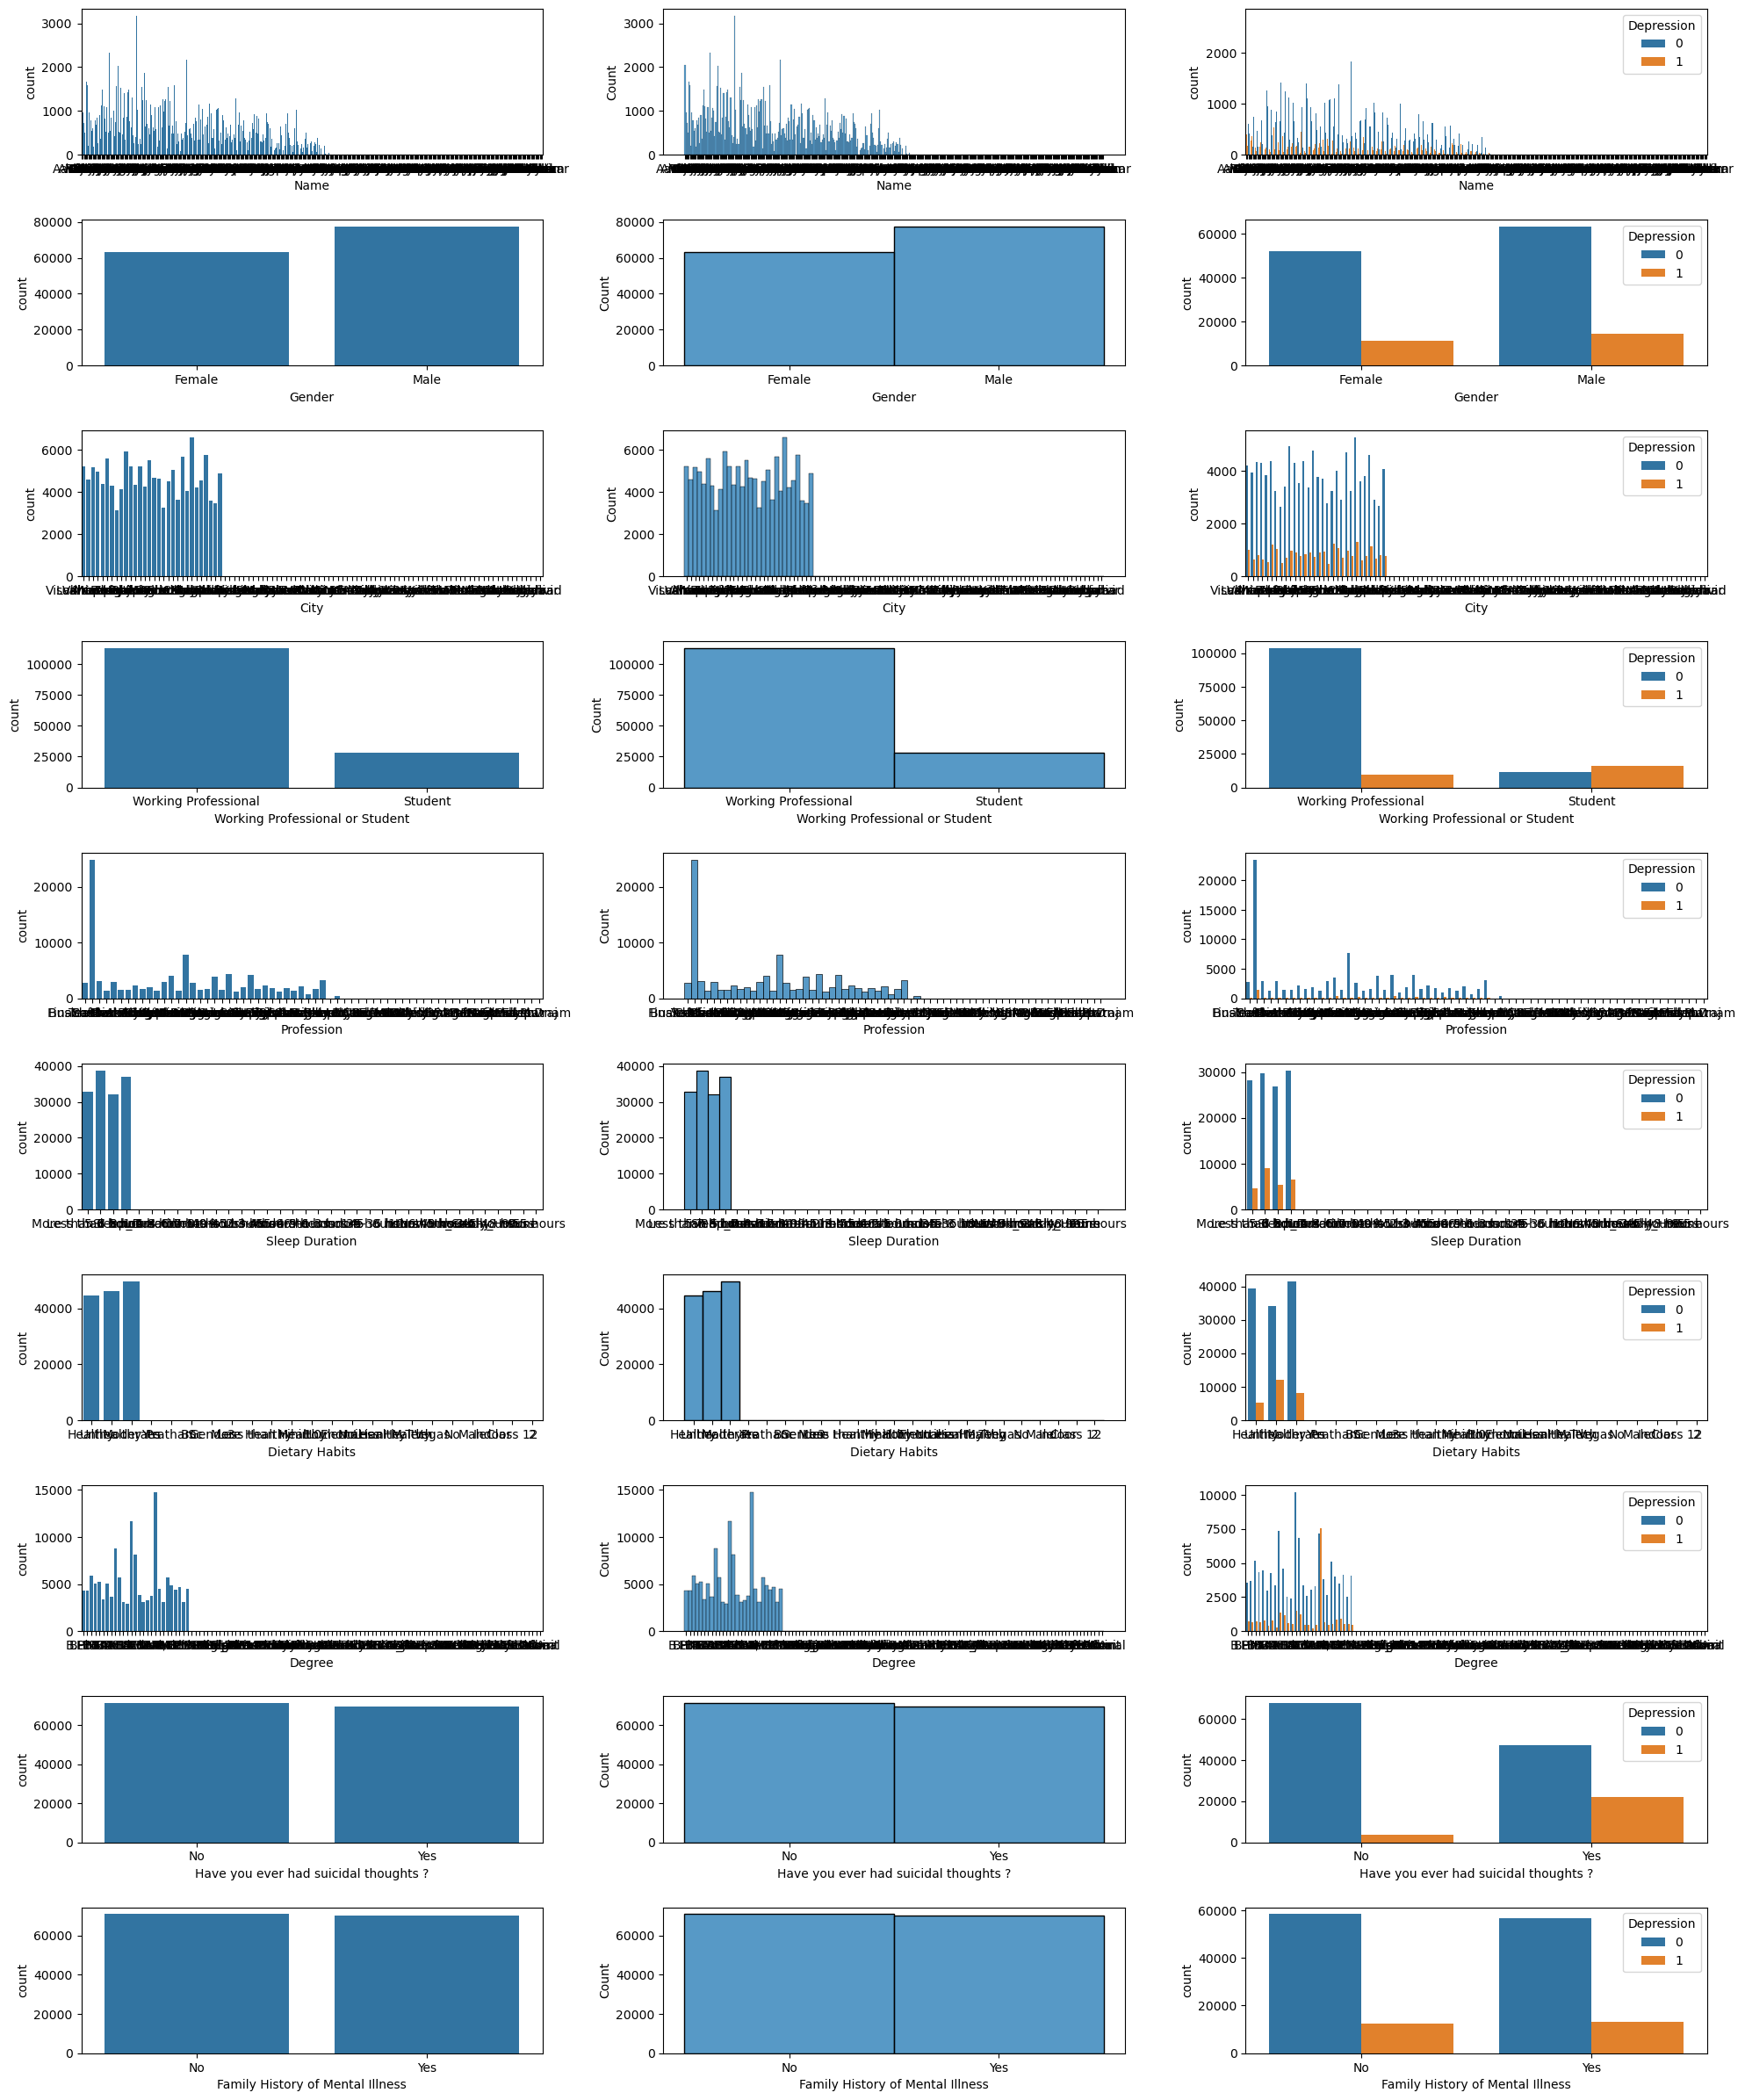

In [89]:
cat_viz(df_train,3,'Depression')

### Основные выводы по EDA

-  Дисбаланс классов
-  Грязные данные по: 
    - 'Degree',
    - 'Dietary Habits',
    - 'Sleep Duration',
    - 'Profession',
    - 'City',
    - 'Name'
- Большое кол-во пропусков по:
    - 'Study Satisfaction',
    - 'Academic Pressure',
    - 'CGPA'
- Сразу можем декодировать в 1 и 0:
    - 'Have you ever had suicidal thoughts ?',
    - 'Family History of Mental Illness',
    - 'Have you ever had suicidal thoughts ?'
    - 'Working Professional or Student'
- Можем дропнуть:
    - 'id',
    - 'Name'
    - 'Study Satisfaction',
    - 'Academic Pressure',
    - 'CGPA'

### Feature Engeneering

In [90]:
#Дропним ненужные колонки и запомним их названия ,они нам еще понадобятся

for_drop = ['id','Name','Study Satisfaction','Academic Pressure','CGPA']
after_drops = df_train.drop(columns = for_drop)
missings(after_drops,0)

,Total,Percent
Profession,36630,26.034115
Work Pressure,27918,19.842217
Job Satisfaction,27910,19.836532
Dietary Habits,4,0.002843
Financial Stress,4,0.002843
Degree,2,0.001421


In [91]:
after_drops.shape

(140700, 15)

In [92]:
#Декодируем часть переменных

gender_dict = {'Male':1,'Female':0}
suicidal_thoughts = {'Yes':1,'No':0}
Family_History = {'Yes':1,'No':0}
working = {'Working Professional':1,'Student':0}

after_drops['Gender']=after_drops['Gender'].map(gender_dict)
after_drops['Have you ever had suicidal thoughts ?']=after_drops['Have you ever had suicidal thoughts ?'].map(suicidal_thoughts)
after_drops['Family History of Mental Illness']=after_drops['Family History of Mental Illness'].map(Family_History)
after_drops['Working Professional or Student'] = after_drops['Working Professional or Student'].map(working)

- Посмотрим детальнее на:
    - 'Degree','Dietary Habits','Sleep Duration','Profession','City'

In [93]:
#Profession
pd.DataFrame(after_drops['Profession'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Profession,count
0,Teacher,17.701493
1,Content Writer,5.553660
2,Architect,3.105899
3,Consultant,3.005686
4,HR Manager,2.858564
5,Pharmacist,2.766880
6,Doctor,2.313433
7,Business Analyst,2.246624
8,Entrepreneur,2.109453
9,Chemist,2.108742


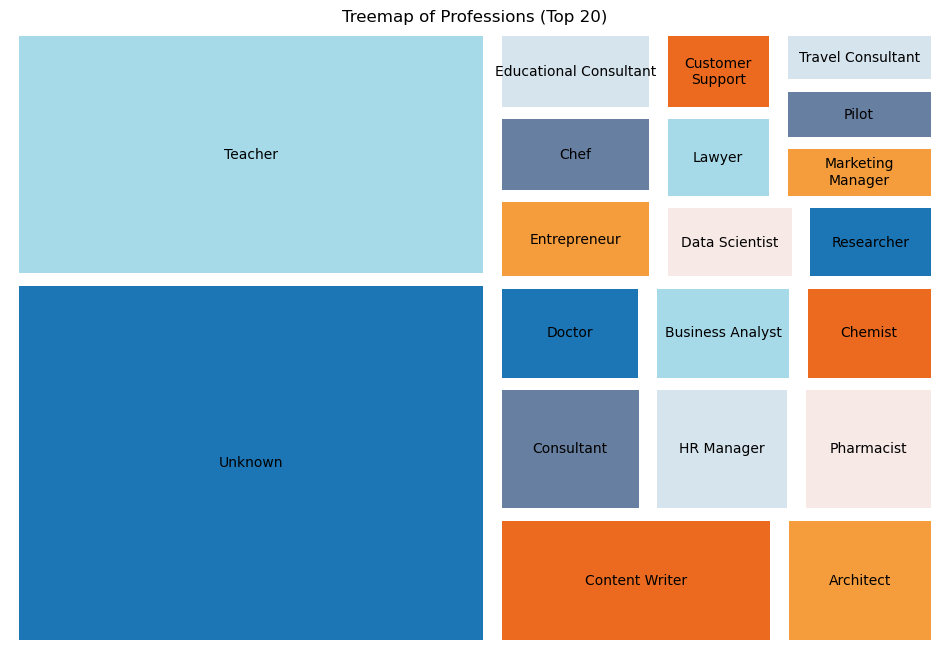

In [166]:
# Calculate frequencies

value_counts = after_drops['Profession'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

# Modify specific labels to show on two lines and limit to top 20 labels
labels = [
    "Customer\nSupport" if label == "Customer Support" else
    "Marketing\nManager" if label == "Marketing Manager" else
    label
    for label in value_counts.index[:20]
]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, pad=True)
plt.title(f"Treemap of Professions (Top 20)")
plt.axis("off")
plt.show()

In [ ]:
# Get the top 10 most common professions
top_professions = after_drops['Degree'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 professions
filtered_df = after_drops[df_train['Degree'].isin(top_professions)]

# Create a new DataFrame for aggregation
agg_data = filtered_df.groupby(['Degree', 'Depression']).size().reset_index(name='Count')

# Create a sunburst chart
fig = px.sunburst(agg_data, 
                  path=['Degree', 'Depression'], 
                  values='Count', 
                  title='Sunburst Chart of Top 10 Degrees and Depression',
                  color='Count',
                  color_continuous_scale=px.colors.sequential.Oranges[:])

# Show the figure
fig.show()

In [94]:
#Попросим ChatGPT объединить наши профессии в группы

after_drops['Profession'].unique()

array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Yu

In [95]:
#Вот такой словарь выдал GPT

profession_to_category = {
    # Information Technology and Data Analysis
    'Software Engineer': 'IT and Data Analysis',
    'Data Scientist': 'IT and Data Analysis',
    'Business Analyst': 'IT and Data Analysis',
    'Research Analyst': 'IT and Data Analysis',
    'Consultant': 'IT and Data Analysis',
    'Analyst': 'IT and Data Analysis',
    'LLM': 'IT and Data Analysis',
    'Dev': 'IT and Data Analysis',

    #Content

    'UX/UI Designer': 'Content',
    'Graphic Designer': 'Content',
    'Content Writer': 'Content',

    # Education and Consulting

    'Teacher': 'Education and Consulting',
    'Educational Consultant': 'Education and Consulting',
    'Family Consultant': 'Education and Consulting',
    'Academic': 'Education and Consulting',
    'Researcher': 'Education and Consulting',
    'Travel Consultant': 'Education and Consulting',

    # Engineering and Technical Professions

    'Civil Engineer': 'Engineering and Technical Professions',
    'Mechanical Engineer': 'Engineering and Technical Professions',
    'Electrical Engineer': 'Engineering and Technical Professions',
    'Architect': 'Engineering and Technical Professions',
    'Electrician': 'Engineering and Technical Professions',
    'Plumber': 'Engineering and Technical Professions',

    # Medicine and Pharmacy

    'Doctor': 'Medicine and Pharmacy',
    'Medical Doctor': 'Medicine and Pharmacy',
    'Pharmacist': 'Medicine and Pharmacy',
    'MBBS': 'Medicine and Pharmacy',
    'Chemist': 'Medicine and Pharmacy',

    # Finance and Accounting

    'Accountant': 'Finance and Accounting',
    'Investment Banker': 'Finance and Accounting',
    'Financial Analyst': 'Finance and Accounting',
    'Finanancial Analyst': 'Finance and Accounting',

    # Marketing and Sales

    'Marketing Manager': 'Marketing and Sales',
    'Sales Executive': 'Marketing and Sales',
    'Customer Support': 'Marketing and Sales',
    'City Manager': 'Marketing and Sales',
    'Digital Marketer': 'Marketing and Sales',

    # Law and Judiciary

    'Lawyer': 'Law and Judiciary',
    'Judge': 'Law and Judiciary',
    

    # Management and Administration

    'Manager': 'Management and Administration',
    'HR Manager': 'Management and Administration',
    'City Manager': 'Management and Administration',

    # Culinary

    'Chef': 'Culinary',

    # Other Spec

    'Entrepreneur': 'Other Spec',
    'Unemployed': 'Other Spec',
    'Pilot': 'Other Spec',
    'Student': 'Other Spec',
    'Working Professional': 'Other Spec'

}

In [96]:
after_drops['Profession_Category'] = after_drops['Profession'].map(profession_to_category)

In [97]:
pd.DataFrame(after_drops['Profession_Category'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Profession_Category,count
0,Education and Consulting,22.709311
1,IT and Data Analysis,8.517413
2,Content,7.412225
3,Engineering and Technical Professions,7.353945
4,Medicine and Pharmacy,7.190476
5,Marketing and Sales,5.076048
6,Management and Administration,4.093817
7,Other Spec,3.476901
8,Finance and Accounting,3.294243
9,Law and Judiciary,2.788913


In [98]:
#Посмотрим какие остались профессии с пустыми категориями професиий

after_drops['Profession'][after_drops['Profession_Category'].isnull()].value_counts()

Profession
Yogesh           3
BCA              3
Profession       3
MBA              2
PhD              2
B.Com            1
Nagpur           1
Visakhapatnam    1
Pranav           1
M.Ed             1
Moderate         1
Unveil           1
B.Ed             1
BE               1
Patna            1
BBA              1
FamilyVirar      1
Yuvraj           1
Name: count, dtype: int64

In [100]:
#Убираем из выборки мусорные данные

strange_profession = after_drops['Profession'][after_drops['Profession_Category'].isnull()].value_counts().index.to_list()

after_drops = after_drops[~after_drops['Profession'].isin(strange_profession)]
missings(after_drops,0)

,Total,Percent
Profession,36630,26.038927
Profession_Category,36630,26.038927
Work Pressure,27918,19.845885
Job Satisfaction,27910,19.840198
Dietary Habits,4,0.002843
Financial Stress,4,0.002843
Degree,2,0.001422


In [101]:
#Теперь надо заполнить пропуски в Profession_Category и Profession
#Сделаем просто Unknown 

after_drops['Profession_Category'].fillna('Unknown', inplace=True)
after_drops['Profession'].fillna('Unknown', inplace=True)


In [102]:
#Посмаотрим 'Degree'

pd.DataFrame(after_drops['Degree'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Degree,count
0,Class 12,10.470307
1,B.Ed,8.309993
2,B.Arch,6.214368
3,B.Com,5.765102
4,B.Pharm,4.162816
5,BCA,4.077513
6,M.Ed,4.027752
7,MCA,3.720659
8,BBA,3.574932
9,BSc,3.571378


In [103]:
after_drops['Degree'].unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'UX/UI Designer', 'MPA', 'BH', 'Nalini', 'BEd',
       'B.Sc', 'Veda', 'Bhopal', 'S.Tech', 'Degree', '20', 'Class 11',
       'H_Pharm', 'M', 'P.Com', 'BPharm', 'Business Analyst', 'M.Arch',
       'LL.Com', 'Data Scientist', 'MPharm', 'L.Ed', 'P.Pharm', 'Kalyan',
       'Unite', 'BArch', 'HR Manager', 'Badhya', 'S.Pharm', 'LLBA',
       'Vrinda', 'M. Business Analyst', 'Bhavesh', '0', 'LLCom', '29',
       'MTech', 'Vivaan', 'BPA', 'Plumber', '5.61', 'Brit', 'B.03',
       'Ritik', '5.56', 'MEd', 'B', 'B BA', '7.06', 'ACA', 'Brithika',
       'CGPA', '24', 'M_Tech', 'Pihu', 'BB', 'Jhanvi', 'LLTech', 'Aarav',
       'Entrepreneur', '8.56', 'LHM', 'Lata', 'S.Arch', 'Marsh', 'HCA',
       '5.88', 'B.Student', 'LL B.Ed', 'M.S', 'Navya', 'Mahika', nan,


In [104]:
#Словарь по образованию

education_to_category = {
    # Бакалавриат
    'BBA': 'Undergraduate', 'BSc': 'Undergraduate', 'B.Arch': 'Undergraduate',
    'BCA': 'Undergraduate', 'BE': 'Undergraduate', 'B.Ed': 'Undergraduate',
    'B.Com': 'Undergraduate', 'B.Tech': 'Undergraduate', 'BPharm': 'Undergraduate',
    'B.Sc': 'Undergraduate', 'BArch': 'Undergraduate', 'BHM': 'Undergraduate',
    'BPA': 'Undergraduate', 'B BA': 'Undergraduate', 'B.03': 'Undergraduate',
    'LLB': 'Undergraduate','B.Pharm': 'Undergraduate', 'BA': 'Undergraduate',

    # Магистратура
    'MCA': 'Postgraduate', 'ME': 'Postgraduate', 'MA': 'Postgraduate',
    'MBA': 'Postgraduate', 'M.Com': 'Postgraduate', 'MHM': 'Postgraduate',
    'M.Tech': 'Postgraduate', 'M.Ed': 'Postgraduate', 'MSc': 'Postgraduate',
    'M.Pharm': 'Postgraduate', 'MPA': 'Postgraduate', 'M.Arch': 'Postgraduate',
    'MPharm': 'Postgraduate', 'M_Tech': 'Postgraduate', 'MTech': 'Postgraduate',

    # Профессиональные и специальные степени
    'MD': 'Professional Degree', 'MBBS': 'Professional Degree', 'PhD': 'Doctoral Degree',
    'LLM': 'Professional Degree', 'LL.Com': 'Professional Degree', 'L.Ed': 'Professional Degree',
    'LLCom': 'Professional Degree', 'LL B.Ed': 'Professional Degree', 'S.Tech': 'Professional Degree',
    'S.Arch': 'Professional Degree', 'LLTech': 'Professional Degree', 'ACA': 'Professional Certification',

    # Среднее образование
    'Class 11': 'High School', 'Class 12': 'High School',

    # Общее образование
    'Degree': 'General Education', 'BB': 'General Education', 'B.3.79': 'General Education',
    'LCA': 'General Education', 'RCA': 'General Education', 'P.Com': 'General Education',
    'S.Pharm': 'General Education', 'H_Pharm': 'General Education', 'N.Pharm': 'General Education',

    # Прочее (не относится к академическим степеням)
    'Business Analyst': 'Professional', 'Data Scientist': 'Professional', 'HR Manager': 'Professional',
    'UX/UI Designer': 'Professional', 'Plumber': 'Professional', 'Entrepreneur': 'Professional',
    'Working Professional': 'Professional', 'Doctor': 'Professional'
}

# Опционально: значения, которые можно удалить или очистить
remove_values = ['Nalini', 'Veda', 'Bhopal', 'Kalyan', 'Unite', 'Vrinda', 
                 'Bhavesh', 'Vivaan', 'Brit', 'Ritik', 'Brithika', 'Jhanvi', 
                 'Aarav', 'Lata', 'Navya', 'Mahika', 'Pihu', 'Esha', 'Advait', 
                 'Mihir', '20', '5.61', '5.56', '7.06', '8.56', '0', '29', '24', 'CGPA','M','LLBA','MEd','B','BEd','BH',
 'B.Student','E.Tech','LLEd','LLS','Mthanya','K.Ed','M.S','Marsh','5.88','HCA','LHM','M. Business Analyst','Badhya','P.Pharm','B B.Com']

In [105]:
after_drops['Education'] = after_drops['Degree'].map(education_to_category)

In [120]:
#Убираем нераспознанные Degree

after_drops = after_drops[~after_drops['Degree'].isin(remove_values)]
after_drops = after_drops[after_drops['Education'] != 'Professional']

In [121]:
after_drops['Degree'].value_counts()

Degree
Class 12    14729
B.Ed        11690
B.Arch       8742
B.Com        8110
B.Pharm      5856
BCA          5736
M.Ed         5666
MCA          5234
BBA          5029
BSc          5024
MSc          4877
LLM          4647
M.Pharm      4537
M.Tech       4475
B.Tech       4425
LLB          4347
BHM          4305
MBA          3816
BA           3750
ME           3631
MD           3382
MHM          3286
BE           3102
PhD          3101
M.Com        3093
MBBS         3082
MA           2887
M.Arch          5
B.Sc            3
P.Com           2
BPharm          2
LL B.Ed         2
L.Ed            2
BArch           2
Degree          2
S.Tech          1
B BA            1
LCA             1
N.Pharm         1
B.3.79          1
S.Arch          1
LLTech          1
BB              1
M_Tech          1
ACA             1
MTech           1
B.03            1
BPA             1
LLCom           1
S.Pharm         1
MPharm          1
LL.Com          1
MPA             1
H_Pharm         1
Class 11        1
RCA

In [122]:
after_drops['Degree'][after_drops['Education'].isnull()].value_counts()

Series([], Name: count, dtype: int64)

In [123]:
missings(after_drops,0)

,Total,Percent
Work Pressure,27894,19.838978
Job Satisfaction,27886,19.833288
Dietary Habits,4,0.002845
Financial Stress,4,0.002845
Degree,2,0.001422
Education,2,0.001422


In [124]:
pd.DataFrame(after_drops['Education'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Education,count
0,Undergraduate,49.875535
1,Postgraduate,29.523762
2,High School,10.476380
3,Professional Degree,7.908849
4,Doctoral Degree,2.205516
5,General Education,0.007824
6,Professional Certification,0.000711


In [125]:
pd.DataFrame(after_drops['Degree'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Degree,count
0,Class 12,10.475669
1,B.Ed,8.314249
2,B.Arch,6.217550
3,B.Com,5.768055
4,B.Pharm,4.164948
5,BCA,4.079601
6,M.Ed,4.029815
7,MCA,3.722564
8,BBA,3.576763
9,BSc,3.573207


In [126]:
#Заполним пропуски Unknown

after_drops['Education'].fillna('Unknown', inplace=True)
after_drops['Degree'].fillna('Unknown', inplace=True)


In [128]:
#Dietary Habits

pd.DataFrame(after_drops['Dietary Habits'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Dietary Habits,count
0,Moderate,35.322399
1,Unhealthy,32.853018
2,Healthy,31.805380
3,Yes,0.001422
4,No,0.001422
5,More Healthy,0.001422
6,No Healthy,0.000711
7,Class 12,0.000711
8,Indoor,0.000711
9,Male,0.000711


In [129]:
#Сразу дропним маленькие значения

after_drops = after_drops[after_drops['Dietary Habits'].isin(['Moderate','Unhealthy','Healthy'])]

In [130]:
missings(after_drops,0)

,Total,Percent
Work Pressure,27882,19.834252
Job Satisfaction,27874,19.828561
Financial Stress,4,0.002845


In [131]:
#'Sleep Duration'
pd.DataFrame(after_drops['Sleep Duration'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Sleep Duration,count
0,Less than 5 hours,27.564645
1,7-8 hours,26.272808
2,More than 8 hours,23.261604
3,5-6 hours,22.844745
4,3-4 hours,0.008536
5,6-7 hours,0.005691
6,4-5 hours,0.004980
7,2-3 hours,0.003557
8,4-6 hours,0.003557
9,6-8 hours,0.002845


In [132]:
#Дропним маленькие значения

after_drops = after_drops[after_drops['Sleep Duration'].isin(['Less than 5 hours','7-8 hours','More than 8 hours','5-6 hours'])]

In [133]:
pd.DataFrame(after_drops['Sleep Duration'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,Sleep Duration,count
0,Less than 5 hours,27.580145
1,7-8 hours,26.287581
2,More than 8 hours,23.274684
3,5-6 hours,22.857590


In [134]:
#City
pd.DataFrame(after_drops['City'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,City,count
0,Kalyan,4.686254
1,Patna,4.211508
2,Vasai-Virar,4.098337
3,Kolkata,4.042820
4,Ahmedabad,3.987302
5,Meerut,3.928937
6,Ludhiana,3.714697
7,Pune,3.704732
8,Rajkot,3.700461
9,Visakhapatnam,3.679820


In [135]:
#Объединим их в регионы

after_drops['City'].unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna',
       'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush',
       'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay',
       'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi',
       'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh',
       'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth',
       'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata',
       'Researcher', '

In [136]:
cities_by_size_and_status = {
    "Megapolis": [
        "Mumbai", "Delhi", "Bangalore", "Hyderabad", 
        "Ahmedabad", "Chennai", "Kolkata"
    ],
    "Big City": [
        "Pune", "Surat", "Kanpur", "Jaipur", 
        "Nagpur", "Indore", "Thane", "Bhopal", 
        "Lucknow", "Patna", "Varanasi", "Ludhiana", 
        "Visakhapatnam", "Vadodara", "Vasai-Virar", 
        "Faridabad", "Ghaziabad"
    ],
    "Small City": [
        "Nashik", "Rajkot", "Meerut", "Agra", 
        "Kalyan", "Srinagar", "Morena"
    ]
}

In [137]:
# Создаем функцию для получения региона по городу

def get_region(city):
    for region, cities in cities_by_size_and_status.items():
        if city in cities:
            return region
    return 'Unknown'  # если города нет в списке, возвращаем 'Unknown'

# Применяем функцию к колонке с городами
after_drops['City Size'] = after_drops['City'].apply(get_region)

In [138]:
pd.DataFrame(after_drops['City Size'].value_counts()/after_drops.shape[0]*100).reset_index().style.background_gradient(subset=['count'], cmap='Reds')

,City Size,count
0,Big City,55.329689
1,Megapolis,23.116672
2,Small City,21.484597
3,Unknown,0.069041


In [139]:

strange_city = after_drops['City'][after_drops['City Size']=='Unknown'].value_counts().index.to_list()

after_drops = after_drops[~after_drops['City'].isin(strange_city)]

In [140]:
strange_city

['Mihir',
 'Nandini',
 'Pratyush',
 'Mahi',
 'City',
 'Vidya',
 'Bhavna',
 'Saanvi',
 'Harsha',
 'Nalini',
 'Molkata',
 'Ayush',
 'Atharv',
 'M.Com',
 'MCA',
 'Keshav',
 'Rashi',
 'No',
 'Chhavi',
 'Researcher',
 'Vaishnavi',
 'MSc',
 'ME',
 'Tushar',
 'Parth',
 'Ishanabad',
 'Kagan',
 'Armaan',
 'Ithal',
 'Kashish',
 'Nalyan',
 'Dhruv',
 'Galesabad',
 'Itheg',
 'Aaradhya',
 'Pooja',
 'Khushi',
 'Khaziabad',
 'Jhanvi',
 'Kibara',
 'Krinda',
 'Reyansh',
 'Harsh',
 'Gurgaon',
 'Krishna',
 'Aishwarya',
 'Aditya',
 'Malyansh',
 'Raghavendra',
 'M.Tech',
 'Less Delhi',
 'Plata',
 '3.0',
 'Less than 5 Kalyan',
 'Mira',
 'Moreadhyay',
 'Ishkarsh',
 'Kashk',
 'Tolkata',
 'Anvi',
 'Vidhi',
 'Ayansh',
 'Shrey',
 'Ivaan',
 'Vaanya',
 'Gaurav',
 'Unirar']

In [141]:
after_drops[after_drops['City'].isin(strange_city)]

,Gender,Age,City,Working Professional or Student,Profession,Work Pressure,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Profession_Category,Education,City Size


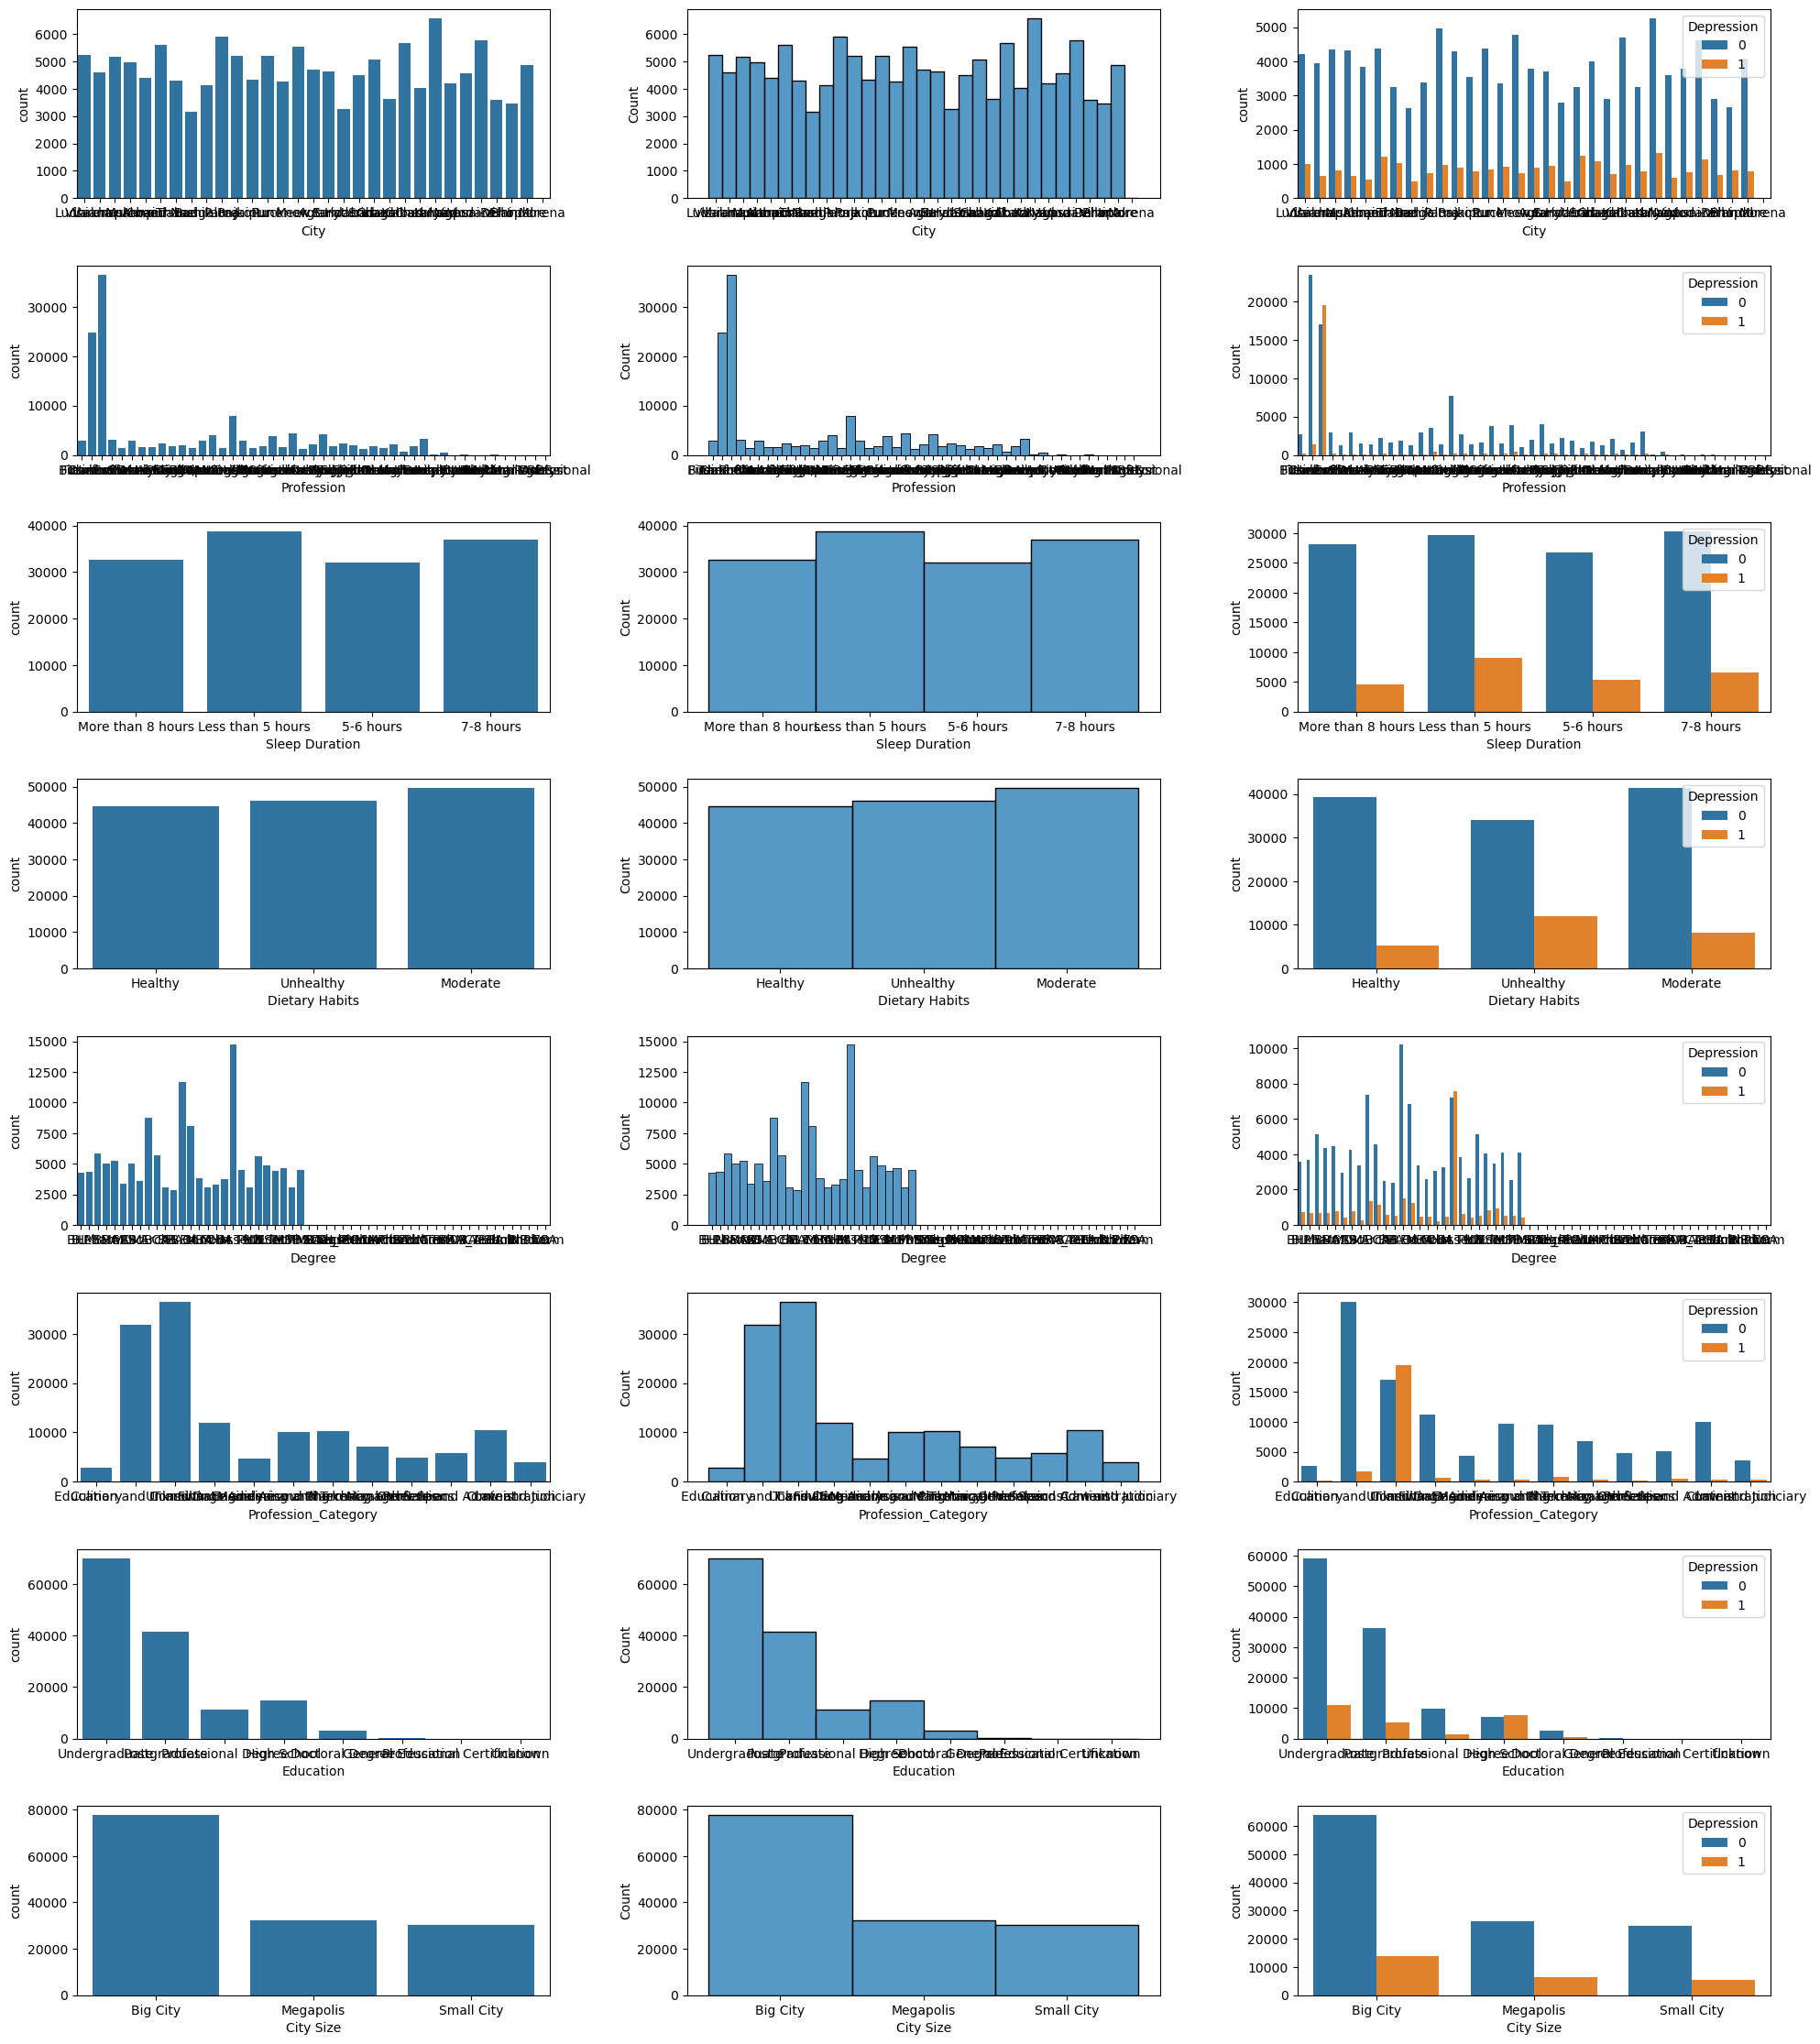

In [142]:
cat_viz(after_drops,3,'Depression')

In [143]:
missings(after_drops,0).index.to_list()

['Work Pressure', 'Job Satisfaction', 'Financial Stress']

In [144]:
after_drops['Work Pressure'].dropna().unique().tolist()

[5.0, 4.0, 1.0, 2.0, 3.0]

In [145]:
after_drops['Work Pressure'].value_counts()

Work Pressure
2.0    24328
4.0    22472
5.0    22388
3.0    21847
1.0    21526
Name: count, dtype: int64

In [147]:
#Заполним пропуски по 'Work Pressure' так же равномерно по категориям


def fill_missing_uniformly(df, column_name, values):
    # Считаем количество пропусков
    n_missing = df[column_name].isna().sum()
    
    # Генерируем случайные значения с равномерным распределением для пропусков
    
    fill_values = np.random.choice(values, size=n_missing, replace=True)
    
    # Заполняем пропуски
    
    df.loc[df[column_name].isna(), column_name] = fill_values
    return df


In [148]:
# Применение функции для заполнения пропусков
values = after_drops['Work Pressure'].dropna().unique().tolist()
after_drops = fill_missing_uniformly(after_drops, 'Work Pressure',values)

In [149]:
missings(after_drops,0)

,Total,Percent
Job Satisfaction,27830,19.822079
Financial Stress,4,0.002849


In [150]:
after_drops['Work Pressure'].value_counts()

Work Pressure
2.0    29844
4.0    28038
5.0    27873
3.0    27509
1.0    27135
Name: count, dtype: int64

In [151]:
after_drops['Job Satisfaction'].value_counts()

Job Satisfaction
2.0    24736
5.0    22773
1.0    22284
3.0    21906
4.0    20870
Name: count, dtype: int64

In [152]:
#Тоже самое сделаем и для Job Satisfaction

values = after_drops['Job Satisfaction'].dropna().unique().tolist()
after_drops = fill_missing_uniformly(after_drops, 'Job Satisfaction',values)

In [153]:
after_drops['Job Satisfaction'].value_counts()

Job Satisfaction
2.0    30261
5.0    28466
1.0    27918
3.0    27349
4.0    26405
Name: count, dtype: int64

In [154]:
missings(after_drops,0)

,Total,Percent
Financial Stress,4,0.002849


In [155]:
after_drops['Financial Stress'].value_counts()

Financial Stress
2.0    31393
5.0    28225
4.0    27705
1.0    27137
3.0    25935
Name: count, dtype: int64

In [156]:
#Тоже самое сделаем и для Financial Stress

values = after_drops['Financial Stress'].dropna().unique().tolist()
after_drops = fill_missing_uniformly(after_drops, 'Financial Stress',values)

In [157]:
after_drops['Financial Stress'].value_counts()

Financial Stress
2.0    31393
5.0    28227
4.0    27705
1.0    27139
3.0    25935
Name: count, dtype: int64

In [158]:
missings(after_drops,0)

,Total,Percent


In [159]:
after_drops['Working Professional or Student'].value_counts()

Working Professional or Student
1    112578
0     27821
Name: count, dtype: int64

In [101]:
#Осталось произвести декодирование категориальных переменных
after_drops['City'].unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore'], dtype=object)

In [ ]:
#Корреляции и проверка на влияния факторов но сначала полное декодирование категориальных переменных

mi = mutual_info_classif(after_drops.drop(columns=['Depression']), after_drops['Depression'])
feature_importance = pd.Series(mi, index=df.columns[:-1])

ValueError: could not convert string to float: 'Ludhiana'